In [3]:
!pip3 install numpy xgboost torchvision optuna catboost pandas seaborn imblearn


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from catboost import CatBoostClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, Dataset
from xgboost import XGBClassifier


/Users/danila/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import warnings

warnings.filterwarnings("ignore")


# ===============
# ЗАГРУЗКА ДАННЫХ
# ===============

In [6]:
%%time
csv_files = [
    "data/02-14-2018.csv",
    "data/02-15-2018.csv",
    "data/02-16-2018.csv",
    "data/02-20-2018.csv",
    "data/02-21-2018.csv",
    "data/02-22-2018.csv",
    "data/02-23-2018.csv",
    "data/02-28-2018.csv",
    "data/03-01-2018.csv",
    "data/03-02-2018.csv",
]

all_dfs = [pd.read_csv(f, low_memory=False) for f in csv_files]
df1, df2, df3, df4, df5, df6, df7, df8, df9, df10 = all_dfs


CPU times: user 1min 34s, sys: 2min 35s, total: 4min 10s
Wall time: 5min 4s


In [7]:
columns_to_remove = ["Flow ID", "Src IP", "Src Port", "Dst IP"]
df4.drop(columns=columns_to_remove, inplace=True)


In [8]:
dfs = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]

for i in range(len(dfs)):
    dfs[i] = dfs[i][dfs[i]["Label"] != "Label"]

df1, df2, df3, df4, df5, df6, df7, df8, df9, df10 = dfs


# ====================
# ПРЕДОБРАБОТКА ДАННЫХ
# ====================

In [9]:
def concatenate_dataframes(dataframe_list):
    combined_df = pd.concat(dataframe_list, axis=0, ignore_index=True)
    print(f"Объединенный датафрейм: {combined_df.shape}")
    return combined_df


Объединенный датафрейм: (16232943, 80)


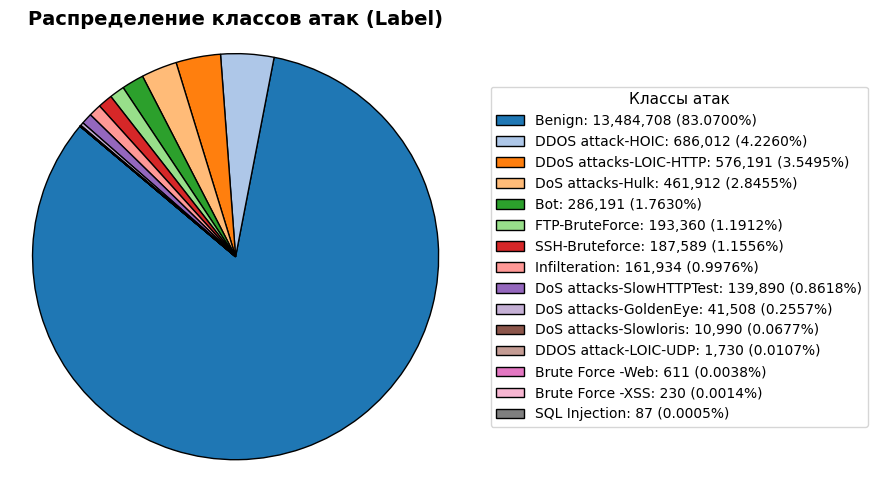

In [10]:
df = concatenate_dataframes([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10])


label_counts = df["Label"].value_counts().sort_values(ascending=False)
labels = label_counts.index
sizes = label_counts.values

colors = plt.cm.tab20.colors[: len(labels)]

fig, ax = plt.subplots(figsize=(9, 5))

wedges, texts = ax.pie(
    sizes, startangle=140, colors=colors, wedgeprops=dict(edgecolor="k", linewidth=1)
)

legend_labels = [
    f"{label}: {size:,} ({size / sizes.sum() * 100:.4f}%)"
    for label, size in zip(labels, sizes)
]

ax.legend(
    wedges,
    legend_labels,
    title="Классы атак",
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    fontsize=10,
    title_fontsize=11,
)

ax.set_title("Распределение классов атак (Label)", fontsize=14, weight="bold")
ax.axis("equal")
plt.tight_layout()
plt.show()


In [11]:
def correct_dtypes(dataframe):
    dataframe = dataframe[dataframe["Dst Port"] != "Dst Port"]

    int_columns = [
        "Dst Port",
        "Protocol",
        "Flow Duration",
        "Tot Fwd Pkts",
        "Tot Bwd Pkts",
        "TotLen Fwd Pkts",
        "TotLen Bwd Pkts",
        "Fwd Pkt Len Max",
        "Fwd Pkt Len Min",
        "Bwd Pkt Len Max",
        "Bwd Pkt Len Min",
        "Flow IAT Max",
        "Flow IAT Min",
        "Fwd IAT Tot",
        "Fwd IAT Max",
        "Fwd IAT Min",
        "Bwd IAT Tot",
        "Bwd IAT Max",
        "Bwd IAT Min",
        "Fwd PSH Flags",
        "Bwd PSH Flags",
        "Fwd URG Flags",
        "Bwd URG Flags",
        "Fwd Header Len",
        "Bwd Header Len",
        "FIN Flag Cnt",
        "SYN Flag Cnt",
        "RST Flag Cnt",
        "PSH Flag Cnt",
        "ACK Flag Cnt",
        "URG Flag Cnt",
        "CWE Flag Count",
        "ECE Flag Cnt",
        "Down/Up Ratio",
        "Fwd Byts/b Avg",
        "Fwd Pkts/b Avg",
        "Fwd Blk Rate Avg",
        "Bwd Byts/b Avg",
        "Bwd Pkts/b Avg",
        "Bwd Blk Rate Avg",
        "Subflow Fwd Pkts",
        "Subflow Fwd Byts",
        "Subflow Bwd Pkts",
        "Subflow Bwd Byts",
        "Init Fwd Win Byts",
        "Init Bwd Win Byts",
        "Fwd Act Data Pkts",
        "Fwd Seg Size Min",
        "Active Max",
        "Active Min",
        "Idle Max",
        "Idle Min",
        "Pkt Len Max",
        "Pkt Len Min",
    ]
    float_columns = [
        "Fwd Pkt Len Mean",
        "Fwd Pkt Len Std",
        "Bwd Pkt Len Mean",
        "Bwd Pkt Len Std",
        "Flow Byts/s",
        "Flow Pkts/s",
        "Flow IAT Mean",
        "Flow IAT Std",
        "Fwd IAT Mean",
        "Fwd IAT Std",
        "Bwd IAT Mean",
        "Bwd IAT Std",
        "Fwd Pkts/s",
        "Bwd Pkts/s",
        "Pkt Len Mean",
        "Pkt Len Std",
        "Pkt Len Var",
        "Pkt Size Avg",
        "Fwd Seg Size Avg",
        "Bwd Seg Size Avg",
        "Active Mean",
        "Active Std",
        "Idle Mean",
        "Idle Std",
    ]

    for col in int_columns:
        dataframe[col] = dataframe[col].astype(int)

    for col in float_columns:
        dataframe[col] = dataframe[col].astype(float)

    return dataframe


In [12]:
%%time
all_dfs = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]
processed_dfs = [correct_dtypes(tbl) for tbl in all_dfs]

df1, df2, df3, df4, df5, df6, df7, df8, df9, df10 = processed_dfs


CPU times: user 7.33 s, sys: 5.2 s, total: 12.5 s
Wall time: 24.2 s


In [13]:
def clean_infinite_values(dataframe):
    print("Изначальный размер:", dataframe.shape)

    dataframe.replace(["Infinity", "infinity"], np.inf, inplace=True)
    dataframe.replace([np.inf, -np.inf], np.nan, inplace=True)

    before_drop = len(dataframe)
    dataframe.dropna(inplace=True)
    after_drop = len(dataframe)
    print(f"Удалено {before_drop - after_drop} строк из-за NaNs или inf.")
    print("Результирующий размер:", dataframe.shape)

    return dataframe


In [14]:
%%time
all_dfs = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]
for idx, tbl in enumerate(all_dfs, start=1):
    print(f"\n df{idx} ...")
    all_dfs[idx - 1] = clean_infinite_values(tbl)

df1, df2, df3, df4, df5, df6, df7, df8, df9, df10 = all_dfs



 df1 ...
Изначальный размер: (1048575, 80)
Удалено 3824 строк из-за NaNs или inf.
Результирующий размер: (1044751, 80)

 df2 ...
Изначальный размер: (1048575, 80)
Удалено 8027 строк из-за NaNs или inf.
Результирующий размер: (1040548, 80)

 df3 ...
Изначальный размер: (1048574, 80)
Удалено 0 строк из-за NaNs или inf.
Результирующий размер: (1048574, 80)

 df4 ...
Изначальный размер: (7948748, 80)
Удалено 59453 строк из-за NaNs или inf.
Результирующий размер: (7889295, 80)

 df5 ...
Изначальный размер: (1048575, 80)
Удалено 0 строк из-за NaNs или inf.
Результирующий размер: (1048575, 80)

 df6 ...
Изначальный размер: (1048575, 80)
Удалено 5610 строк из-за NaNs или inf.
Результирующий размер: (1042965, 80)

 df7 ...
Изначальный размер: (1048575, 80)
Удалено 5708 строк из-за NaNs или inf.
Результирующий размер: (1042867, 80)

 df8 ...
Изначальный размер: (613071, 80)
Удалено 6169 строк из-за NaNs или inf.
Результирующий размер: (606902, 80)

 df9 ...
Изначальный размер: (331100, 80)
Удал

In [15]:
def remove_timestamp_column(dataframe):
    dataframe.drop(labels="Timestamp", axis="columns", inplace=True)
    return dataframe


In [16]:
%%time
all_dfs = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]
for i, tbl in enumerate(all_dfs, start=1):
    print(
        f"\n df{i} ...",
    )
    all_dfs[i - 1] = remove_timestamp_column(tbl)
    print(all_dfs[i - 1].shape)
df1, df2, df3, df4, df5, df6, df7, df8, df9, df10 = all_dfs



 df1 ...
(1044751, 79)

 df2 ...
(1040548, 79)

 df3 ...
(1048574, 79)

 df4 ...
(7889295, 79)

 df5 ...
(1048575, 79)

 df6 ...
(1042965, 79)

 df7 ...
(1042867, 79)

 df8 ...
(606902, 79)

 df9 ...
(328181, 79)

 df10 ...
(1044525, 79)
CPU times: user 534 ms, sys: 1.76 s, total: 2.3 s
Wall time: 2.98 s


In [17]:
def create_threat_column(dataframe, benign_label="Benign"):
    dataframe["Threat"] = dataframe["Label"].apply(
        lambda val: benign_label if val == benign_label else "Malicious"
    )
    print("Threat categories:", dataframe["Threat"].unique())
    print("Threat distribution:\n", dataframe["Threat"].value_counts())
    return dataframe


In [18]:
%%time
all_dfs = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]
for idx, dataf in enumerate(all_dfs, start=1):
    print(f"\n Добаление колонки Threat в df{idx} ...")
    all_dfs[idx - 1] = create_threat_column(dataf, benign_label="Benign")

df1, df2, df3, df4, df5, df6, df7, df8, df9, df10 = all_dfs



 Добаление колонки Threat в df1 ...
Threat categories: ['Benign' 'Malicious']
Threat distribution:
 Threat
Benign       663808
Malicious    380943
Name: count, dtype: int64

 Добаление колонки Threat в df2 ...
Threat categories: ['Benign' 'Malicious']
Threat distribution:
 Threat
Benign       988050
Malicious     52498
Name: count, dtype: int64

 Добаление колонки Threat в df3 ...
Threat categories: ['Benign' 'Malicious']
Threat distribution:
 Threat
Malicious    601802
Benign       446772
Name: count, dtype: int64

 Добаление колонки Threat в df4 ...
Threat categories: ['Benign' 'Malicious']
Threat distribution:
 Threat
Benign       7313104
Malicious     576191
Name: count, dtype: int64

 Добаление колонки Threat в df5 ...
Threat categories: ['Benign' 'Malicious']
Threat distribution:
 Threat
Malicious    687742
Benign       360833
Name: count, dtype: int64

 Добаление колонки Threat в df6 ...
Threat categories: ['Benign' 'Malicious']
Threat distribution:
 Threat
Benign       1042603

In [19]:
def optimize_memory_usage(df, verbose=True):
    numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print(
            "Уменьшение до {:5.2f} Mb (сокращение {:.1f}%)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )

    return df


In [20]:
%%time
all_dfs = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]
all_dfs = [optimize_memory_usage(df) for df in all_dfs]
df1, df2, df3, df4, df5, df6, df7, df8, df9, df10 = all_dfs


Уменьшение до 285.95 Mb (сокращение 55.7%)
Уменьшение до 253.05 Mb (сокращение 60.6%)
Уменьшение до 241.00 Mb (сокращение 62.8%)
Уменьшение до 1971.24 Mb (сокращение 59.6%)
Уменьшение до 241.00 Mb (сокращение 62.3%)
Уменьшение до 285.46 Mb (сокращение 55.7%)
Уменьшение до 257.59 Mb (сокращение 60.0%)
Уменьшение до 151.64 Mb (сокращение 59.6%)
Уменьшение до 81.37 Mb (сокращение 59.9%)
Уменьшение до 259.00 Mb (сокращение 59.9%)
CPU times: user 1.04 s, sys: 1.41 s, total: 2.45 s
Wall time: 2.84 s


In [21]:
attack_category_map = {
    "SSH-Bruteforce": "Brute-force",
    "FTP-BruteForce": "Brute-force",
    "Brute Force -Web": "Web attack",
    "Brute Force -XSS": "Web attack",
    "SQL Injection": "Web attack",
    "DoS attacks-Hulk": "DoS attack",
    "DoS attacks-SlowHTTPTest": "DoS attack",
    "DoS attacks-Slowloris": "DoS attack",
    "DoS attacks-GoldenEye": "DoS attack",
    "DDOS attack-HOIC": "DDoS attack",
    "DDOS attack-LOIC-UDP": "DDoS attack",
    "DDoS attacks-LOIC-HTTP": "DDoS attack",
    "Bot": "Botnet",
    "Infilteration": "Infilteration",
    "Benign": "Benign",
}


def relabel_attacks(df, mapping_dict):
    print("Original labels:\n", df["Label"].value_counts())
    df["Label"] = df["Label"].map(mapping_dict)
    print("\nMapped labels:\n", df["Label"].value_counts())
    return df


In [22]:
%%time
all_dfs = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]
all_dfs = [relabel_attacks(df, attack_category_map) for df in all_dfs]

df1, df2, df3, df4, df5, df6, df7, df8, df9, df10 = all_dfs


Original labels:
 Label
Benign            663808
FTP-BruteForce    193354
SSH-Bruteforce    187589
Name: count, dtype: int64

Mapped labels:
 Label
Benign         663808
Brute-force    380943
Name: count, dtype: int64
Original labels:
 Label
Benign                   988050
DoS attacks-GoldenEye     41508
DoS attacks-Slowloris     10990
Name: count, dtype: int64

Mapped labels:
 Label
Benign        988050
DoS attack     52498
Name: count, dtype: int64
Original labels:
 Label
DoS attacks-Hulk            461912
Benign                      446772
DoS attacks-SlowHTTPTest    139890
Name: count, dtype: int64

Mapped labels:
 Label
DoS attack    601802
Benign        446772
Name: count, dtype: int64
Original labels:
 Label
Benign                    7313104
DDoS attacks-LOIC-HTTP     576191
Name: count, dtype: int64

Mapped labels:
 Label
Benign         7313104
DDoS attack     576191
Name: count, dtype: int64
Original labels:
 Label
DDOS attack-HOIC        686012
Benign                  360833


In [23]:
def balance_by_downsampling(df, label_col="Label"):
    features = df.drop(columns=[label_col])
    target = df[label_col]

    sampler = RandomUnderSampler()
    X_resampled, y_resampled = sampler.fit_resample(features, target)

    balanced_df = pd.concat([X_resampled, y_resampled], axis=1)
    print(f"Сбалансированный размер: {balanced_df.shape}")
    print(balanced_df[label_col].value_counts())

    return balanced_df


In [24]:
%%time
all_dfs = [df1, df2, df3, df4, df5, df6, df7, df8, df9, df10]
all_dfs = [balance_by_downsampling(df) for df in all_dfs]
df1, df2, df3, df4, df5, df6, df7, df8, df9, df10 = all_dfs


Сбалансированный размер: (761886, 80)
Label
Benign         380943
Brute-force    380943
Name: count, dtype: int64
Сбалансированный размер: (104996, 80)
Label
Benign        52498
DoS attack    52498
Name: count, dtype: int64
Сбалансированный размер: (893544, 80)
Label
Benign        446772
DoS attack    446772
Name: count, dtype: int64
Сбалансированный размер: (1152382, 80)
Label
Benign         576191
DDoS attack    576191
Name: count, dtype: int64
Сбалансированный размер: (721666, 80)
Label
Benign         360833
DDoS attack    360833
Name: count, dtype: int64
Сбалансированный размер: (724, 80)
Label
Benign        362
Web attack    362
Name: count, dtype: int64
Сбалансированный размер: (1132, 80)
Label
Benign        566
Web attack    566
Name: count, dtype: int64
Сбалансированный размер: (136472, 80)
Label
Benign           68236
Infilteration    68236
Name: count, dtype: int64
Сбалансированный размер: (184806, 80)
Label
Benign           92403
Infilteration    92403
Name: count, dtype: in

In [25]:
def concatenate_dataframes(dataframe_list):
    combined_df = pd.concat(dataframe_list, axis=0, ignore_index=True)
    print(f"Объединенный датафрейм: {combined_df.shape}")
    return combined_df


In [26]:
%%time
df_all = concatenate_dataframes([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10])
del df1, df2, df3, df4, df5, df6, df7, df8, df9, df10


Объединенный датафрейм: (4529990, 80)
CPU times: user 79 ms, sys: 211 ms, total: 290 ms
Wall time: 428 ms


In [27]:
print(df_all["Label"].value_counts())


Label
Benign           2264995
DDoS attack       937024
DoS attack        499270
Brute-force       380943
Botnet            286191
Infilteration     160639
Web attack           928
Name: count, dtype: int64


In [28]:
def remove_constant_columns(df):
    variances = df.var(numeric_only=True)
    zero_var_cols = variances[variances == 0].index.tolist()
    print(f"Удалено {len(zero_var_cols)} константных признаков: {zero_var_cols}")
    return df.drop(columns=zero_var_cols)


In [29]:
%%time
df_all = remove_constant_columns(df_all)
print("После удаления константных:", df_all.shape)


Удалено 8 константных признаков: ['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg']
После удаления константных: (4529990, 72)
CPU times: user 740 ms, sys: 651 ms, total: 1.39 s
Wall time: 1.66 s


In [30]:
def drop_duplicate_columns(df):
    duplicates = set()
    columns = df.columns
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            if df[columns[i]].equals(df[columns[j]]):
                duplicates.add(columns[j])
    print(f"Найдено {len(duplicates)} дубликатов колонок: {duplicates}")
    return df.drop(columns=list(duplicates))


In [31]:
%%time
df_all = drop_duplicate_columns(df_all)
print("После удаления дубликатов:", df_all.shape)


Найдено 7 дубликатов колонок: {'Bwd Seg Size Avg', 'CWE Flag Count', 'Subflow Fwd Pkts', 'Fwd Seg Size Avg', 'SYN Flag Cnt', 'Subflow Bwd Pkts', 'Subflow Fwd Byts'}
После удаления дубликатов: (4529990, 65)
CPU times: user 816 ms, sys: 182 ms, total: 998 ms
Wall time: 1.01 s


In [32]:
def plot_correlation_matrix(df, title="Корреляционная матрица", figsize=(70, 70)):
    correlation = df.corr(numeric_only=True)
    plt.figure(figsize=figsize)
    sns.heatmap(correlation, annot=True, cmap="crest", vmin=-1, vmax=1, square=True)
    plt.title(title)
    plt.show()
    return correlation


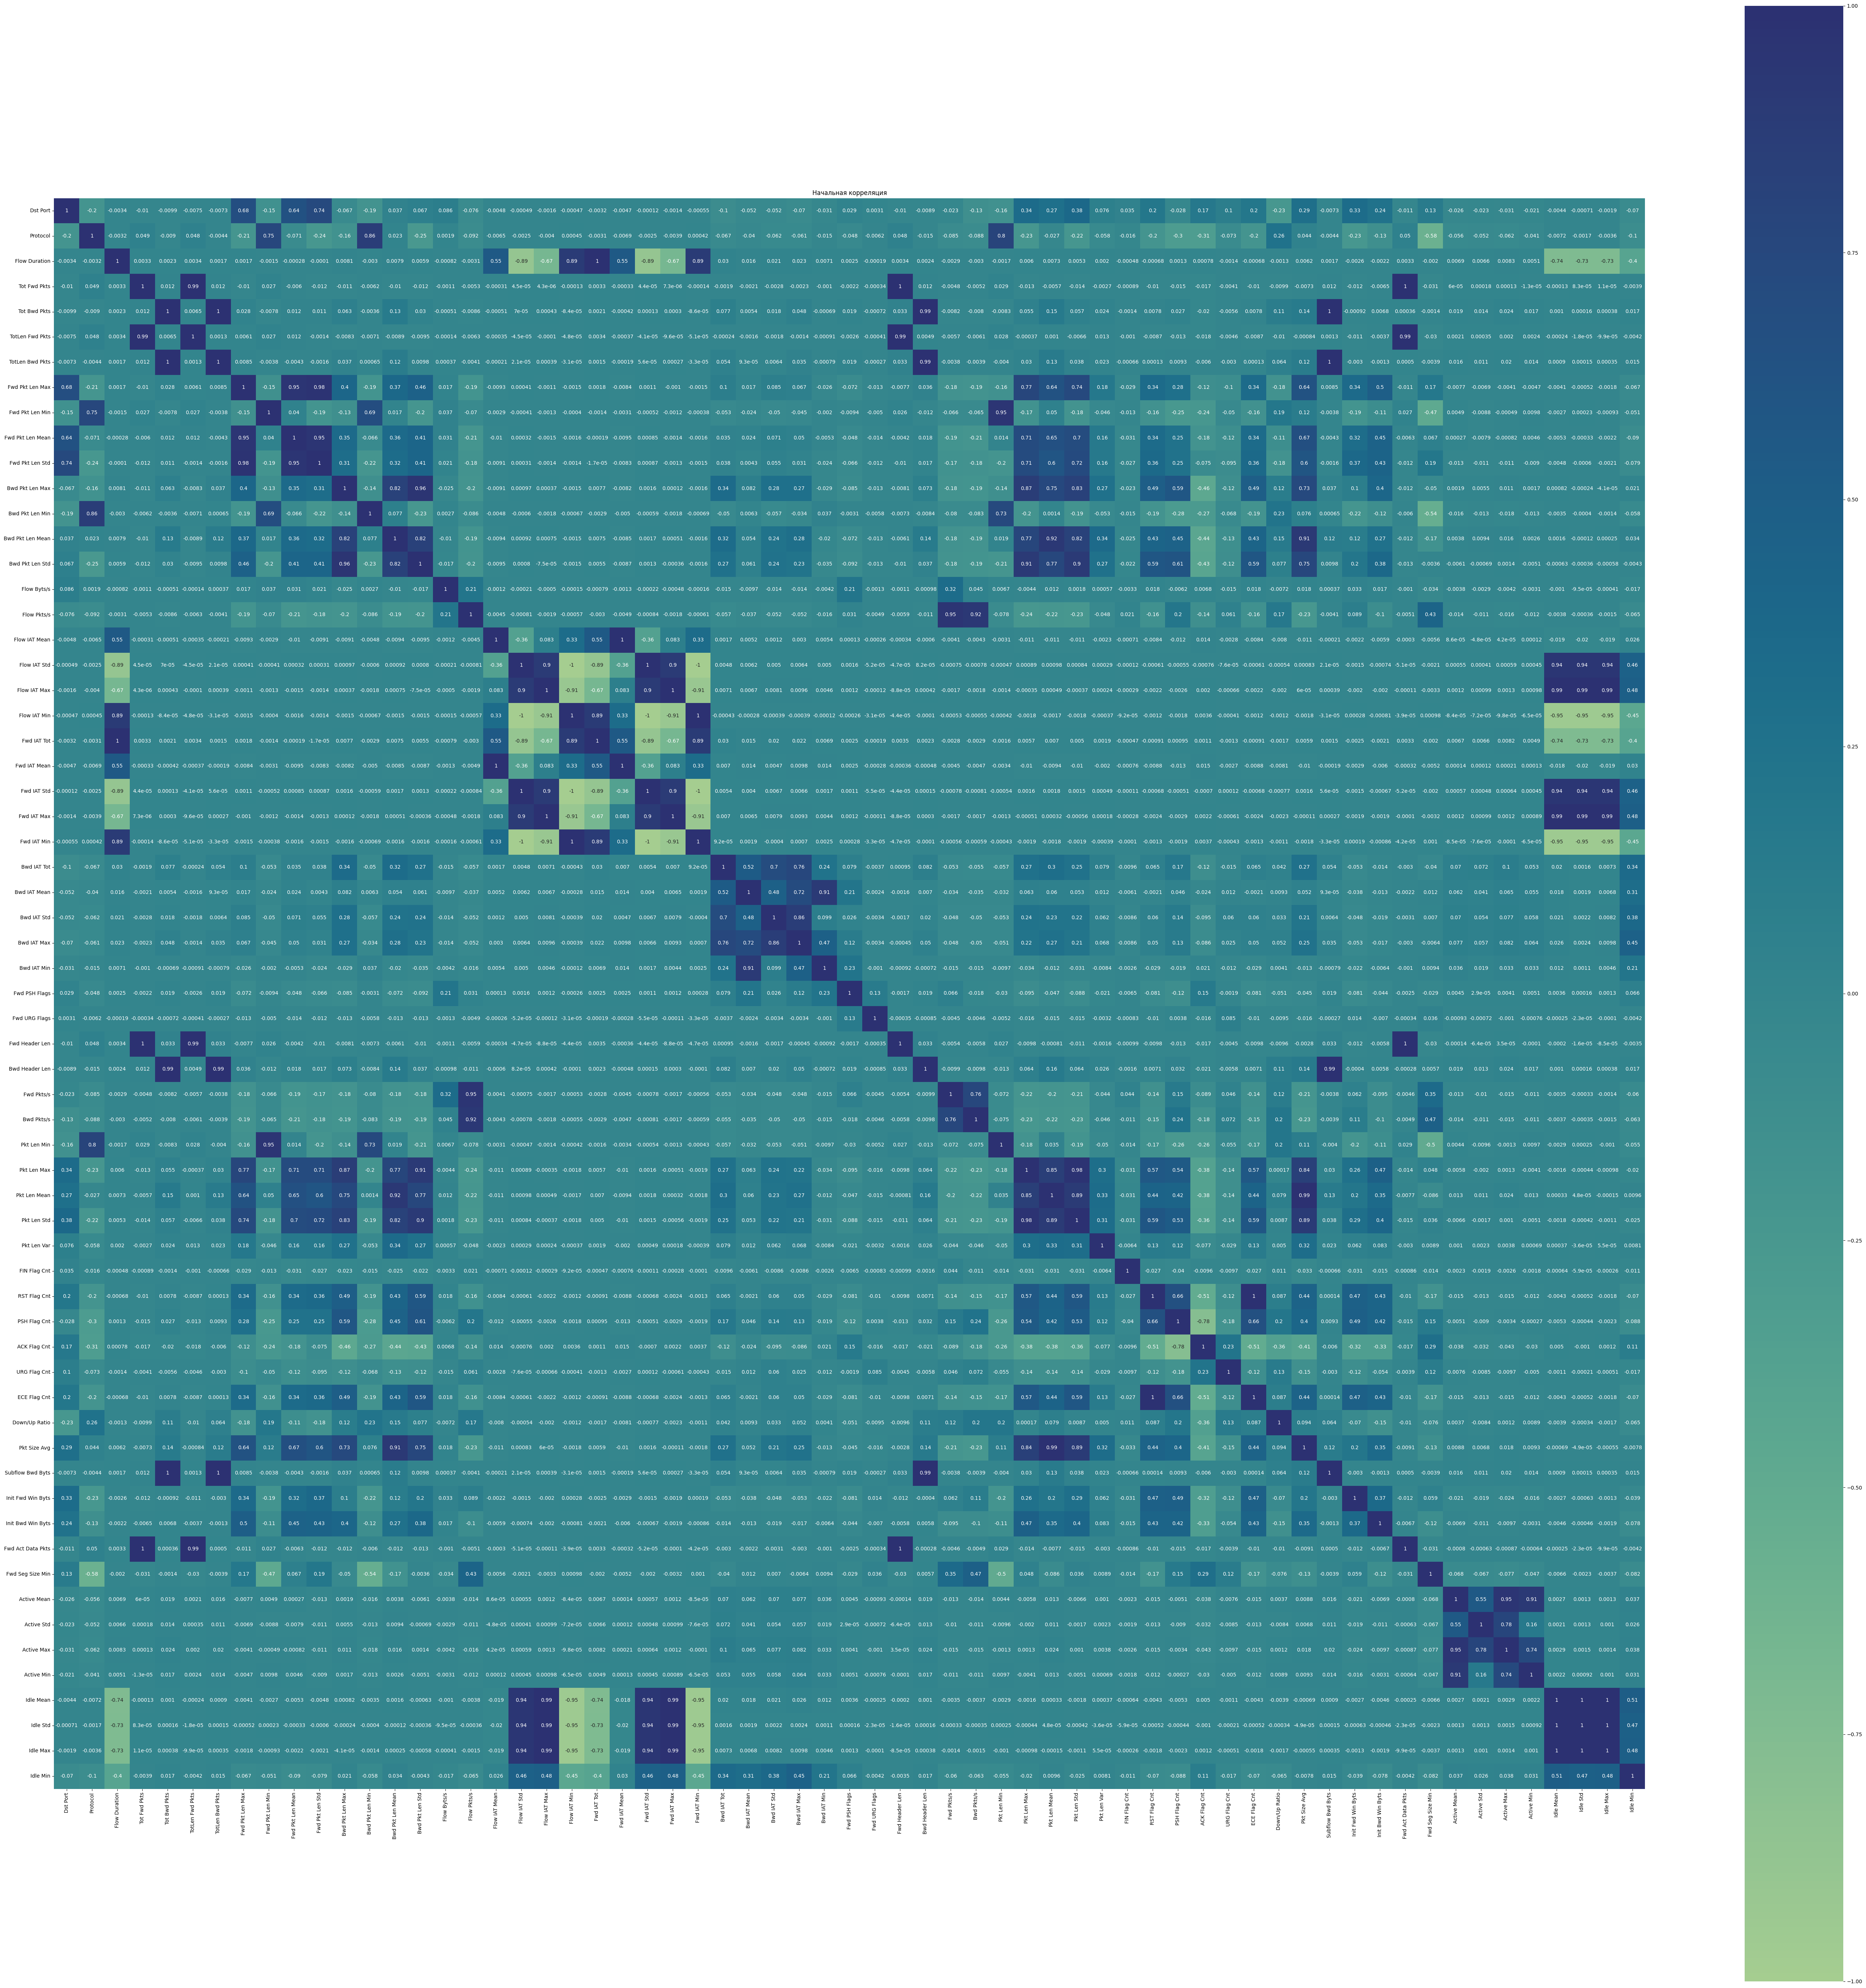

CPU times: user 16.8 s, sys: 752 ms, total: 17.5 s
Wall time: 17.5 s


In [33]:
%%time
corr_matrix = plot_correlation_matrix(df_all, title="Начальная корреляция")


In [34]:
def remove_highly_correlated_features(df, corr_matrix, threshold=0.7):
    correlated_features = set()
    selected = [True] * len(corr_matrix.columns)

    for i in range(len(corr_matrix.columns)):
        if selected[i]:
            for j in range(i):
                if selected[j] and abs(corr_matrix.iloc[i, j]) >= threshold:
                    col_to_remove = corr_matrix.columns[j]
                    correlated_features.add(col_to_remove)
                    selected[j] = False

    print(
        f"Удалено {len(correlated_features)} высококоррелированных признаков: {correlated_features}"
    )
    return df.drop(columns=list(correlated_features))


In [35]:
%%time
df_all = remove_highly_correlated_features(df_all, corr_matrix, threshold=0.7)
print("После удаления коррелирующих признаков:", df_all.shape)


Удалено 40 высококоррелированных признаков: {'Fwd IAT Std', 'Idle Std', 'Bwd IAT Std', 'Bwd Pkt Len Max', 'RST Flag Cnt', 'Fwd IAT Max', 'TotLen Fwd Pkts', 'PSH Flag Cnt', 'Fwd Pkt Len Min', 'Bwd Header Len', 'Bwd IAT Mean', 'Active Mean', 'Idle Mean', 'Flow IAT Std', 'Fwd Pkt Len Std', 'Flow IAT Max', 'Bwd IAT Tot', 'Tot Bwd Pkts', 'Fwd Pkts/s', 'Protocol', 'TotLen Bwd Pkts', 'Flow IAT Min', 'Flow IAT Mean', 'Flow Pkts/s', 'Active Std', 'Fwd IAT Tot', 'Fwd IAT Min', 'Dst Port', 'Pkt Len Max', 'Fwd Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Tot Fwd Pkts', 'Bwd Pkt Len Min', 'Fwd Header Len', 'Active Max', 'Bwd Pkt Len Mean', 'Fwd Pkt Len Mean', 'Flow Duration', 'Bwd Pkt Len Std'}
После удаления коррелирующих признаков: (4529990, 25)
CPU times: user 106 ms, sys: 99.5 ms, total: 206 ms
Wall time: 221 ms


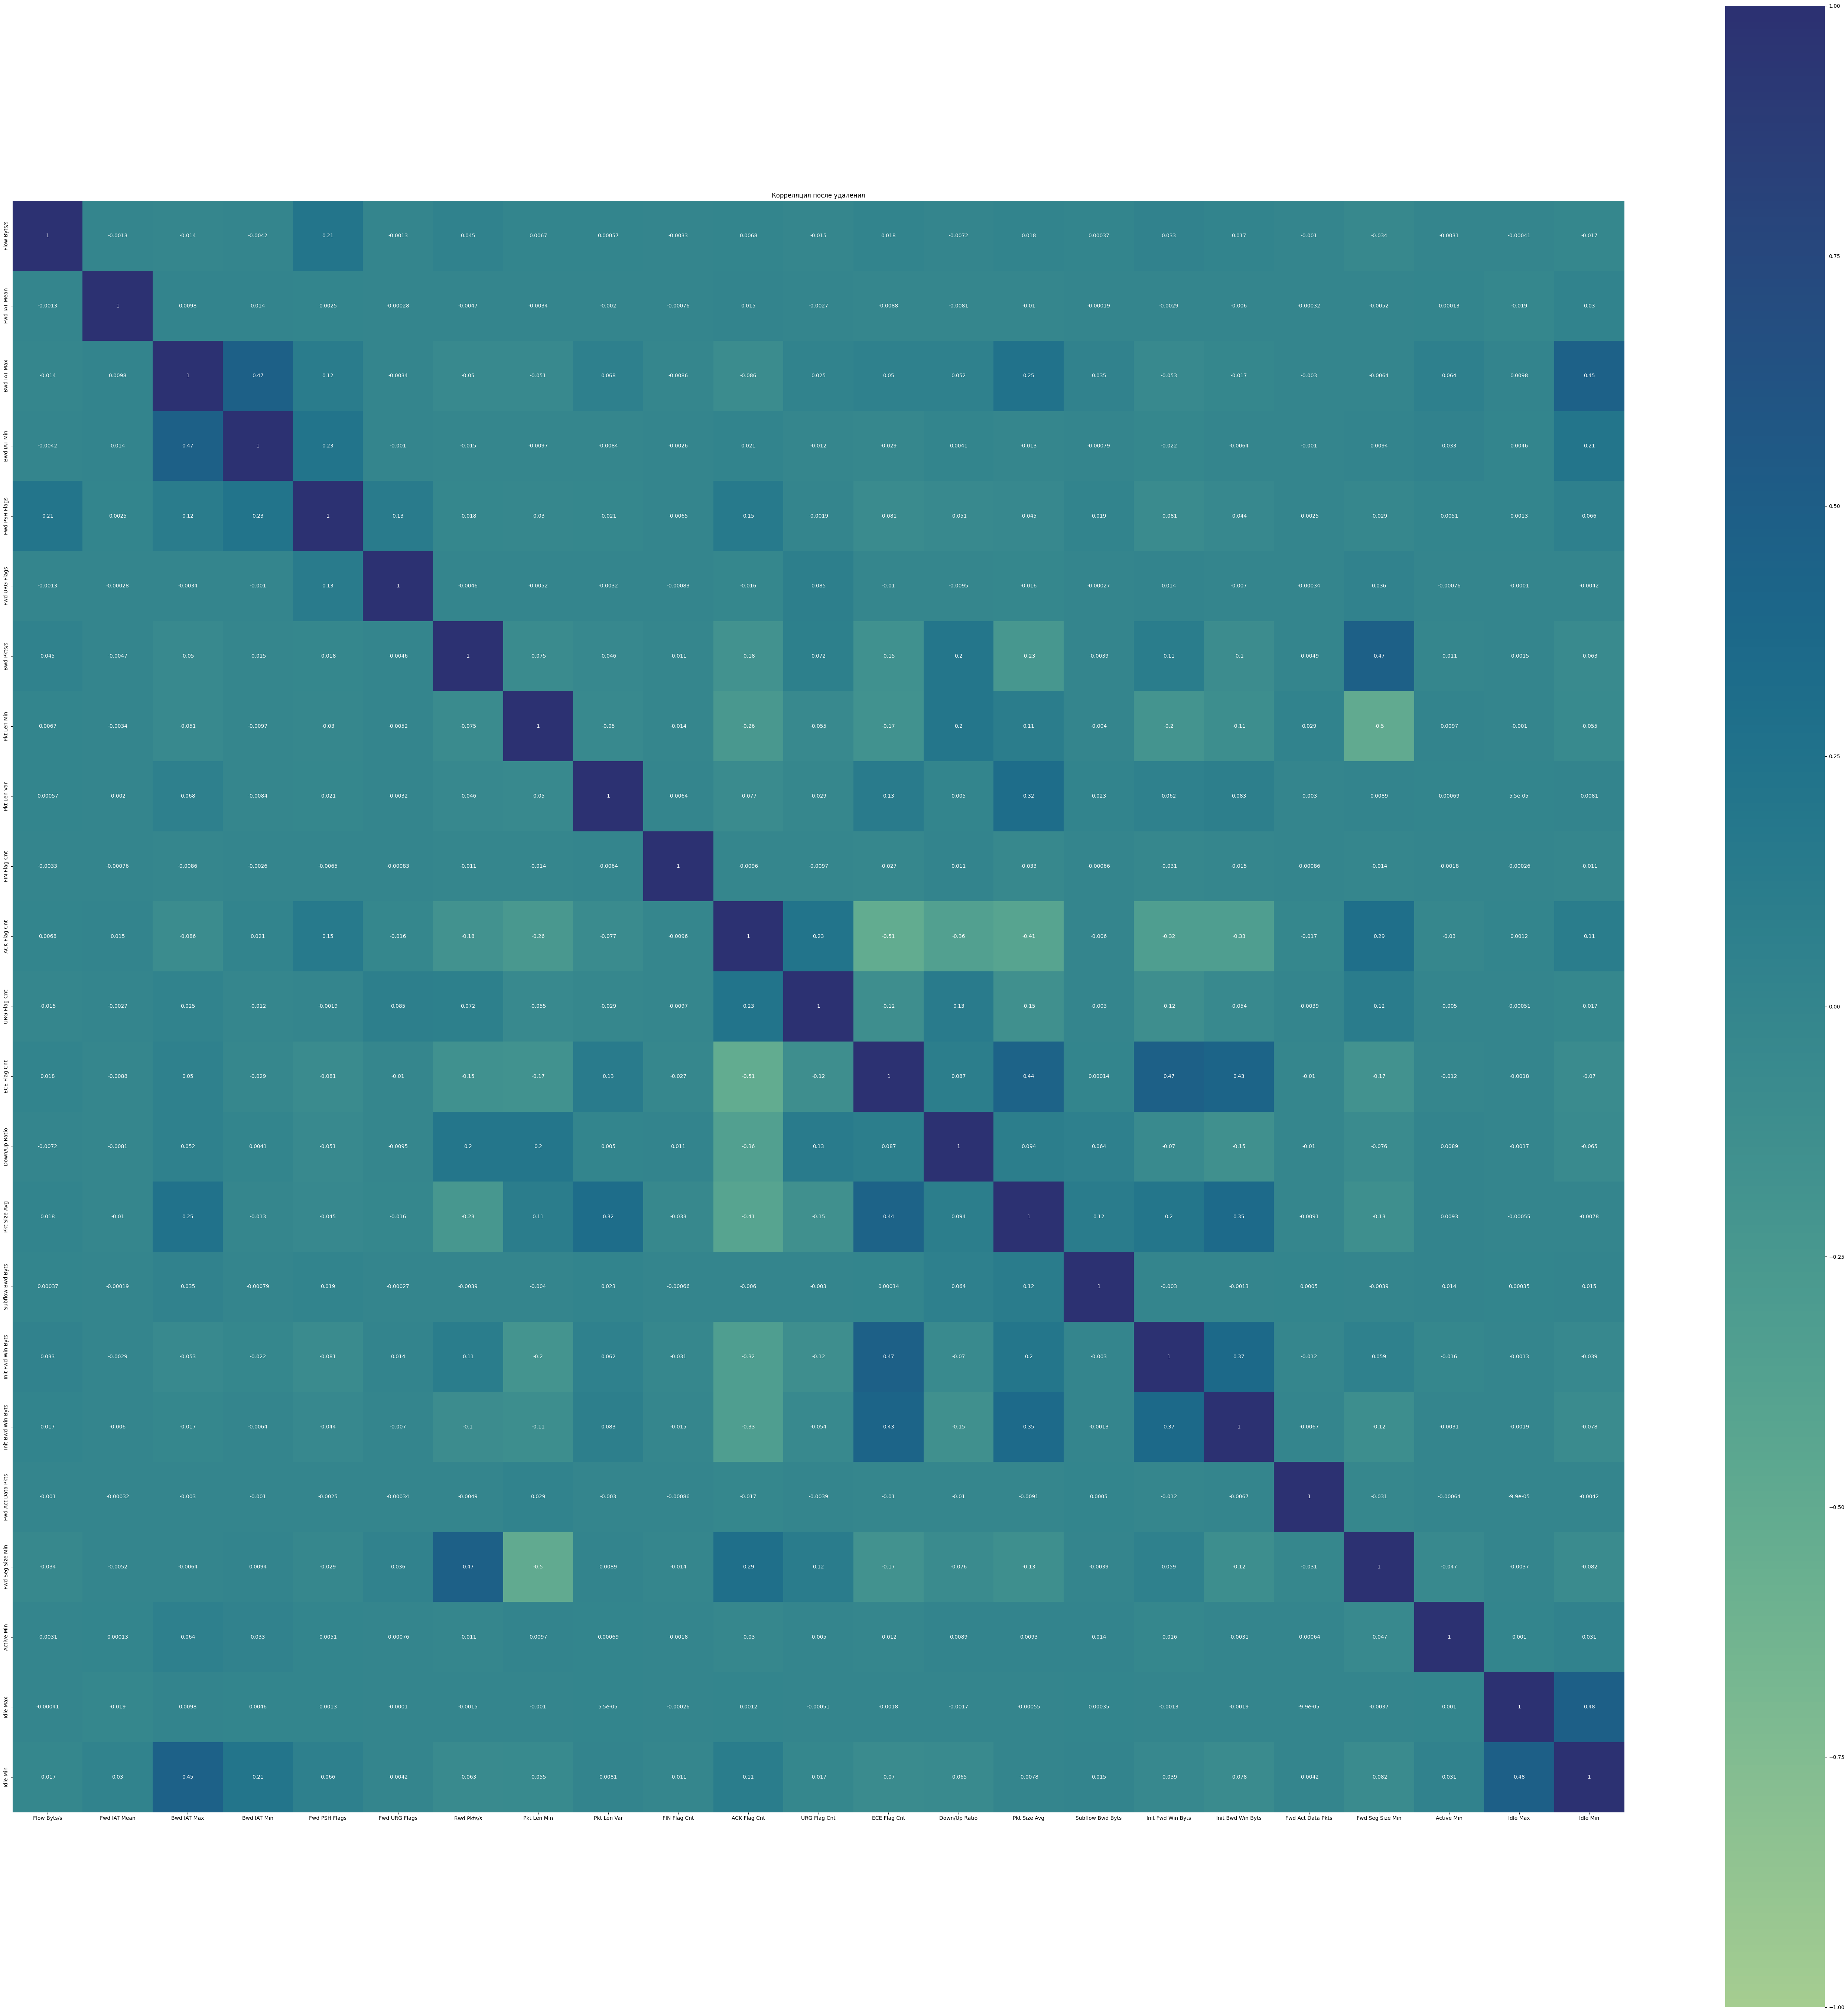

CPU times: user 3.07 s, sys: 124 ms, total: 3.19 s
Wall time: 2.67 s


In [36]:
%%time
_ = plot_correlation_matrix(df_all, title="Корреляция после удаления")


In [37]:
feature_cols = df_all.columns.tolist()
print(f"Количество финальных признаков: {len(feature_cols)}")


Количество финальных признаков: 25


In [38]:
df_all.head()


,Flow Byts/s,Fwd IAT Mean,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Bwd Pkts/s,Pkt Len Min,Pkt Len Var,FIN Flag Cnt,...,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Min,Idle Max,Idle Min,Threat,Label
0,240816.328125,0.000000e+00,0,0,0,0,2040.816284,35,768.000000,0,...,83,-1,-1,0,8,0,0,0,Benign,Benign
1,0.000000,5.479875e+07,0,0,0,0,0.000000,0,0.000000,0,...,0,279,-1,0,20,0,0,0,Benign,Benign
2,83.556885,5.554243e+06,10046566,1,0,0,0.180043,0,228984.718750,0,...,8952,8192,980,15,20,30242,10016223,5501605,Benign,Benign
3,162.300690,1.011702e+06,71767,319,0,0,0.790746,0,24542.253906,0,...,176,8192,946,3,20,0,0,0,Benign,Benign
4,12.540092,3.508746e+06,0,0,0,0,0.000000,33,0.000000,0,...,0,-1,-1,3,8,4522295,6003943,6003943,Benign,Benign


In [39]:
df_all.shape


(4529990, 25)

In [40]:
def print_categorical_values(df):
    for column in df.columns:
        if pd.api.types.is_categorical_dtype(
            df[column]
        ) or pd.api.types.is_object_dtype(df[column]):
            unique_values = df[column].unique()
            print(f"Колонка: {column}")
            print(
                f"Уникальные значения ({len(unique_values)} шт.): {', '.join(map(str, unique_values))}"
            )
            print("-" * 50)


print_categorical_values(df_all)


Колонка: Threat
Уникальные значения (2 шт.): Benign, Malicious
--------------------------------------------------
Колонка: Label
Уникальные значения (7 шт.): Benign, Brute-force, DoS attack, DDoS attack, Web attack, Infilteration, Botnet
--------------------------------------------------


In [41]:
df_all.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4529990 entries, 0 to 4529989
Data columns (total 25 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Flow Byts/s        float32
 1   Fwd IAT Mean       float32
 2   Bwd IAT Max        int32  
 3   Bwd IAT Min        int32  
 4   Fwd PSH Flags      int8   
 5   Fwd URG Flags      int8   
 6   Bwd Pkts/s         float32
 7   Pkt Len Min        int16  
 8   Pkt Len Var        float32
 9   FIN Flag Cnt       int8   
 10  ACK Flag Cnt       int8   
 11  URG Flag Cnt       int8   
 12  ECE Flag Cnt       int8   
 13  Down/Up Ratio      int16  
 14  Pkt Size Avg       float32
 15  Subflow Bwd Byts   int32  
 16  Init Fwd Win Byts  int32  
 17  Init Bwd Win Byts  int32  
 18  Fwd Act Data Pkts  int32  
 19  Fwd Seg Size Min   int8   
 20  Active Min         int32  
 21  Idle Max           int64  
 22  Idle Min           int64  
 23  Threat             object 
 24  Label              object 
dtypes: float32(5), int

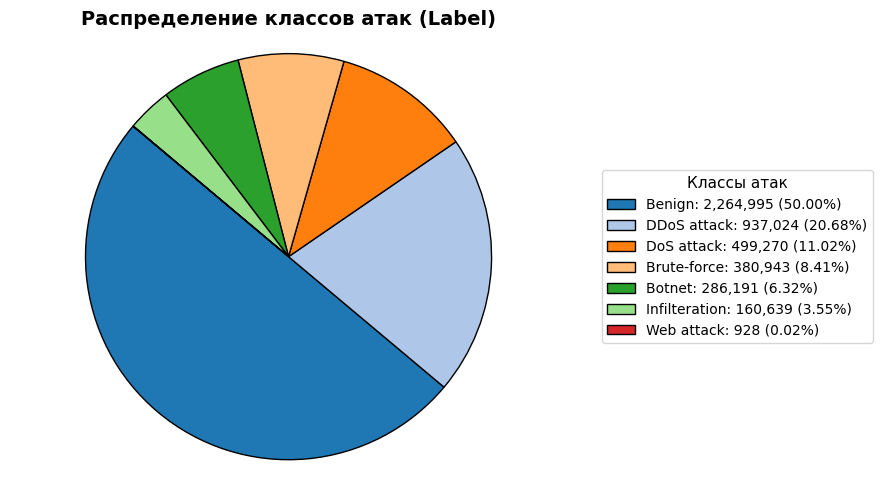

In [42]:
df = df_all.copy()


label_counts = df["Label"].value_counts().sort_values(ascending=False)
labels = label_counts.index
sizes = label_counts.values

colors = plt.cm.tab20.colors[: len(labels)]

fig, ax = plt.subplots(figsize=(9, 5))

wedges, texts = ax.pie(
    sizes, startangle=140, colors=colors, wedgeprops=dict(edgecolor="k", linewidth=1)
)

legend_labels = [
    f"{label}: {size:,} ({size / sizes.sum() * 100:.2f}%)"
    for label, size in zip(labels, sizes)
]

ax.legend(
    wedges,
    legend_labels,
    title="Классы атак",
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    fontsize=10,
    title_fontsize=11,
)

ax.set_title("Распределение классов атак (Label)", fontsize=14, weight="bold")
ax.axis("equal")
plt.tight_layout()

plt.savefig("label_distribution_with_legend.png", dpi=300, bbox_inches="tight")
plt.show()


# ====================
# ПОДГОТОВКА ДАННЫХ
# ====================

In [ ]:
# df_all = pd.read_csv('df_all.csv')
# df_all.drop('Unnamed: 0', axis=1, inplace=True)


In [58]:
# df = df_all.copy().sample(frac=0.005)
df = df_all.copy()
le = LabelEncoder()
df["Label"] = le.fit_transform(df["Label"])
class_names = le.classes_

X = df.drop(["Threat", "Label"], axis=1)
y = df["Label"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=2003
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=2003
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [59]:
def print_class_distribution(y, name):
    class_counts = pd.Series(y).value_counts().sort_index()
    print(f"=== Распределение классов в {name} ===")
    for i, count in class_counts.items():
        print(f"Класс ({class_names[i]}): {count} строк")
    print()


print_class_distribution(y_train, "обучающем наборе (train_part)")
print_class_distribution(y_val, "валидационном наборе (val)")
print_class_distribution(y_test, "тестовом наборе (test)")


=== Распределение классов в обучающем наборе (train_part) ===
Класс (Benign): 1358997 строк
Класс (Botnet): 171715 строк
Класс (Brute-force): 228566 строк
Класс (DDoS attack): 562214 строк
Класс (DoS attack): 299562 строк
Класс (Infilteration): 96383 строк
Класс (Web attack): 557 строк

=== Распределение классов в валидационном наборе (val) ===
Класс (Benign): 452999 строк
Класс (Botnet): 57238 строк
Класс (Brute-force): 76188 строк
Класс (DDoS attack): 187405 строк
Класс (DoS attack): 99854 строк
Класс (Infilteration): 32128 строк
Класс (Web attack): 186 строк

=== Распределение классов в тестовом наборе (test) ===
Класс (Benign): 452999 строк
Класс (Botnet): 57238 строк
Класс (Brute-force): 76189 строк
Класс (DDoS attack): 187405 строк
Класс (DoS attack): 99854 строк
Класс (Infilteration): 32128 строк
Класс (Web attack): 185 строк



In [60]:
from sklearn.preprocessing import label_binarize


def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # Выводим общие метрики
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average="weighted"))
    print("Recall:", recall_score(y_test, y_pred, average="weighted"))
    print("F1-Score:", f1_score(y_test, y_pred, average="weighted"))

    # Считаем ROC AUC для многоклассовой задачи
    try:
        y_proba_df = pd.DataFrame(y_proba, columns=model.classes_)
        y_test_bin = label_binarize(y_test, classes=model.classes_)
        roc_auc_per_class = roc_auc_score(
            y_test_bin, y_proba_df[model.classes_].values, average=None
        )

        roc_auc_weighted = roc_auc_score(
            y_test_bin, y_proba_df[model.classes_].values, average="weighted"
        )
        assert list(y_proba_df.columns) == list(model.classes_), (
            "Mismatch between model.classes_ and predicted probabilities columns"
        )

        print("Weighted ROC-AUC:", roc_auc_weighted)
    except Exception as e:
        print("ROC AUC could not be computed:", e)
        roc_auc_per_class = None

    # Выводим classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # Если ROC AUC удалось посчитать, выводим ее по каждому классу
    if roc_auc_per_class is not None:
        print("ROC-AUC для классов:")
        for class_name, auc_score in zip(class_names, roc_auc_per_class):
            print(f"{class_name}: {auc_score:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Предсказанное значение")
    plt.ylabel("Фактическое значение")
    plt.show()


In [46]:
def plot_top_features(model, feature_names, model_type, n=5):
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
    elif hasattr(model, "coef_"):
        importance = np.mean(np.abs(model.coef_), axis=0)
    else:
        raise ValueError("Модель не поддерживает анализ важности признаков")

    feature_imp = (
        pd.DataFrame({"Feature": feature_names, "Importance": importance})
        .sort_values("Importance", ascending=False)
        .head(n)
    )

    plt.figure(figsize=(6, 4))
    plt.barh(feature_imp["Feature"], feature_imp["Importance"])
    plt.gca().invert_yaxis()
    plt.title(f"Топ {n} признаков - {model_type}")
    plt.xlabel("Значимость")
    plt.show()

    return feature_imp


In [47]:
class_names


array(['Benign', 'Botnet', 'Brute-force', 'DDoS attack', 'DoS attack',
       'Infilteration', 'Web attack'], dtype=object)

# ====================
# RANDOM FOREST
# ====================

[I 2025-04-09 15:24:07,069] A new study created in memory with name: no-name-fff5043f-f78d-46a1-ba63-a970cebf08b5
[I 2025-04-09 15:30:21,876] Trial 0 finished with value: 0.9070458525739794 and parameters: {'n_estimators': 437, 'max_depth': 96, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9070458525739794.
[I 2025-04-09 15:41:30,524] Trial 1 finished with value: 0.9293687060942125 and parameters: {'n_estimators': 973, 'max_depth': 84, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.9293687060942125.
[I 2025-04-09 15:45:22,781] Trial 2 finished with value: 0.9480255195433965 and parameters: {'n_estimators': 363, 'max_depth': 38, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': True, 'class_weight': None}. Best is trial 2 with value: 0.948025519543396


Random Forest Results:
Accuracy: 0.9551257287543681
Precision: 0.9513860334171849
Recall: 0.9551257287543681
F1-Score: 0.9489990653654086
Weighted ROC-AUC: 0.9935844752552387

Classification Report:
               precision    recall  f1-score   support

       Benign       0.95      0.99      0.97    452999
       Botnet       1.00      1.00      1.00     57238
  Brute-force       0.87      0.96      0.91     76189
  DDoS attack       1.00      1.00      1.00    187405
   DoS attack       0.97      0.89      0.93     99854
Infilteration       0.74      0.28      0.41     32128
   Web attack       0.98      0.70      0.81       185

     accuracy                           0.96    905998
    macro avg       0.93      0.83      0.86    905998
 weighted avg       0.95      0.96      0.95    905998

ROC-AUC для классов:
Benign: 0.992
Botnet: 1.000
Brute-force: 0.997
DDoS attack: 1.000
DoS attack: 0.998
Infilteration: 0.947
Web attack: 1.000


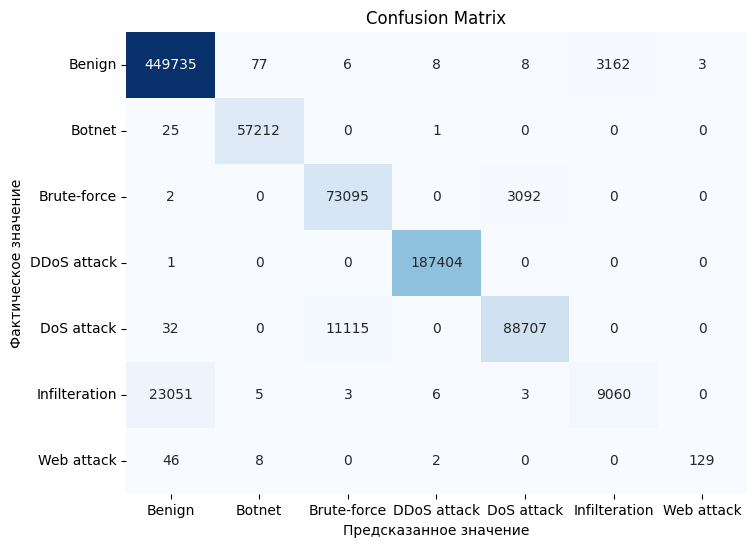

Best Parameters: {'n_estimators': 333, 'max_depth': 67, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': None}

Top 10 Features:


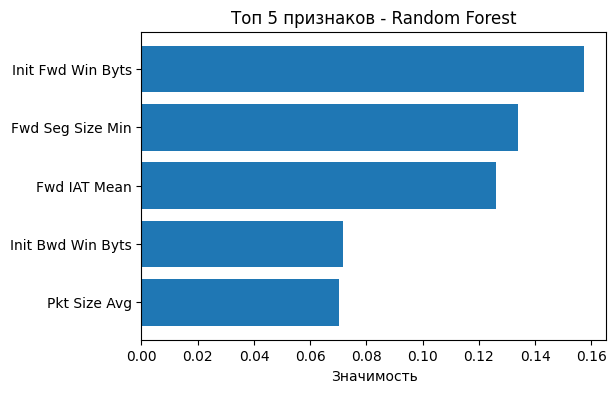

              Feature  Importance
15  Init Fwd Win Byts    0.157497
18   Fwd Seg Size Min    0.134032
1        Fwd IAT Mean    0.126026
16  Init Bwd Win Byts    0.071729
13       Pkt Size Avg    0.070157


In [ ]:
def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "class_weight": trial.suggest_categorical(
            "class_weight", [None, "balanced", "balanced_subsample"]
        ),
    }

    model = RandomForestClassifier(**params, n_jobs=-1, random_state=2003)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred, average="weighted")


sampler = optuna.samplers.TPESampler(seed=42)
study_rf = optuna.create_study(direction="maximize", sampler=sampler)
study_rf.optimize(objective_rf, n_trials=5)

best_rf = RandomForestClassifier(**study_rf.best_params, n_jobs=-1, random_state=2003)
X_train_full = np.vstack((X_train, X_val))
y_train_full = np.concatenate((y_train, y_val))
best_rf.fit(X_train_full, y_train_full)

print("\nRandom Forest Results:")
evaluate_model(best_rf, X_test, y_test)
print("Best Parameters:", study_rf.best_params)

print("\nTop 10 Features:")
feature_imp_rf = plot_top_features(best_rf, X.columns, "Random Forest")
print(feature_imp_rf)


# ====================
# LOGISTIC REGRESSION
# ====================

[I 2025-04-09 16:06:13,453] A new study created in memory with name: no-name-05c54d84-626c-4cc1-9451-04ed902a89a2
[I 2025-04-09 16:19:33,116] Trial 0 finished with value: 0.7035020098286545 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.6860986195995373, 'tol': 0.000778373275052097, 'max_iter': 465, 'class_weight': 'balanced', 'fit_intercept': False}. Best is trial 0 with value: 0.7035020098286545.
[I 2025-04-09 16:21:24,065] Trial 1 finished with value: 0.8313382967379296 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 2.6508851797887907, 'tol': 0.005476027364483275, 'max_iter': 364, 'class_weight': None, 'fit_intercept': True}. Best is trial 1 with value: 0.8313382967379296.
[I 2025-04-09 16:24:20,894] Trial 2 finished with value: 0.6944675142978955 and parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.13952682632655966, 'tol': 0.0029730606901347016, 'max_iter': 943, 'class_weight': 'balanced', 'fit_intercept': True}. Best is trial 1 with value: 0.8313382967


Logistic Regression Results:
Accuracy: 0.8504698685869063
Precision: 0.8534529843401325
Recall: 0.8504698685869063
F1-Score: 0.8405152955251395
Weighted ROC-AUC: 0.9626255332333655

Classification Report:
               precision    recall  f1-score   support

       Benign       0.93      0.89      0.91    452999
       Botnet       0.47      0.55      0.51     57238
  Brute-force       0.77      0.92      0.84     76189
  DDoS attack       0.82      1.00      0.90    187405
   DoS attack       0.91      0.77      0.83     99854
Infilteration       0.65      0.08      0.14     32128
   Web attack       0.00      0.00      0.00       185

     accuracy                           0.85    905998
    macro avg       0.65      0.60      0.59    905998
 weighted avg       0.85      0.85      0.84    905998

ROC-AUC для классов:
Benign: 0.948
Botnet: 0.979
Brute-force: 0.995
DDoS attack: 0.988
DoS attack: 0.989
Infilteration: 0.829
Web attack: 0.570


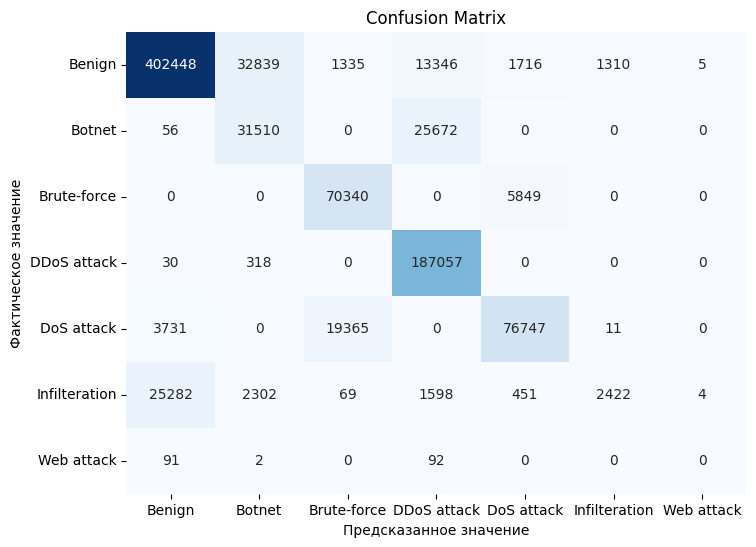

Best Parameters: {'penalty': 'l2', 'solver': 'saga', 'C': 0.5165754484909215, 'tol': 0.0001193784198168397, 'max_iter': 760, 'class_weight': None, 'fit_intercept': True}

Top 10 Features:


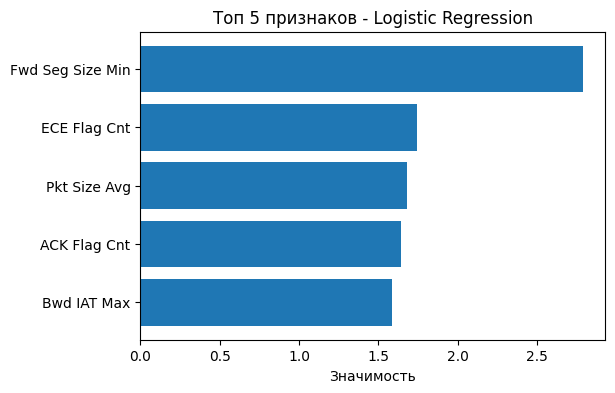

             Feature  Importance
18  Fwd Seg Size Min    2.792305
11      ECE Flag Cnt    1.742686
13      Pkt Size Avg    1.681648
9       ACK Flag Cnt    1.644964
2        Bwd IAT Max    1.587269


In [ ]:
def objective_lr(trial):
    params = {
        "penalty": trial.suggest_categorical("penalty", ["l2"]),
        "solver": trial.suggest_categorical("solver", ["saga"]),
        "C": trial.suggest_float("C", 0.1, 5.0, log=True),
        "tol": trial.suggest_float("tol", 1e-4, 1e-2, log=True),
        "max_iter": trial.suggest_int("max_iter", 100, 1000),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "n_jobs": -1,
    }

    model = LogisticRegression(**params, random_state=2003)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred, average="weighted")


sampler = optuna.samplers.TPESampler(seed=2003)
study_lr = optuna.create_study(direction="maximize", sampler=sampler)
study_lr.optimize(objective_lr, n_trials=5)

best_params = study_lr.best_params
best_lr = LogisticRegression(**best_params, random_state=2003)
X_train_full = np.vstack((X_train, X_val))
y_train_full = np.concatenate((y_train, y_val))
best_lr.fit(X_train_full, y_train_full)

print("\nLogistic Regression Results:")
evaluate_model(best_lr, X_test, y_test)
print("Best Parameters:", best_params)

print("\nTop 10 Features:")
feature_imp_lr = plot_top_features(best_lr, X.columns, "Logistic Regression")
print(feature_imp_lr)


# ====================
# XGBOOST
# ====================

[I 2025-04-09 17:17:57,927] A new study created in memory with name: no-name-6bad99a7-99f7-44fa-b312-6624ffd6eca4
[I 2025-04-09 17:20:58,396] Trial 0 finished with value: 0.948097732090565 and parameters: {'learning_rate': 0.2466528868444864, 'max_depth': 16, 'subsample': 0.7025642340205798, 'colsample_bytree': 0.6731970917172099, 'n_estimators': 863, 'gamma': 1.8836204839738158}. Best is trial 0 with value: 0.948097732090565.
[I 2025-04-09 17:23:53,000] Trial 1 finished with value: 0.9481748539113967 and parameters: {'learning_rate': 0.4868509098584437, 'max_depth': 28, 'subsample': 0.934616402424582, 'colsample_bytree': 0.6466605691107212, 'n_estimators': 846, 'gamma': 1.0176294601422209}. Best is trial 1 with value: 0.9481748539113967.
[I 2025-04-09 17:27:31,946] Trial 2 finished with value: 0.9477371632972605 and parameters: {'learning_rate': 0.32314891455332173, 'max_depth': 16, 'subsample': 0.5425721806517266, 'colsample_bytree': 0.8683009436754004, 'n_estimators': 943, 'gamma': 


XGBoost Results:
Accuracy: 0.9543696564451577
Precision: 0.9501138266977404
Recall: 0.9543696564451577
F1-Score: 0.9486563013466405
Weighted ROC-AUC: 0.9941793004090081

Classification Report:
               precision    recall  f1-score   support

       Benign       0.95      0.99      0.97    452999
       Botnet       1.00      1.00      1.00     57238
  Brute-force       0.87      0.96      0.91     76189
  DDoS attack       1.00      1.00      1.00    187405
   DoS attack       0.96      0.89      0.92     99854
Infilteration       0.71      0.29      0.41     32128
   Web attack       0.93      0.77      0.85       185

     accuracy                           0.95    905998
    macro avg       0.92      0.84      0.87    905998
 weighted avg       0.95      0.95      0.95    905998

ROC-AUC для классов:
Benign: 0.993
Botnet: 1.000
Brute-force: 0.997
DDoS attack: 1.000
DoS attack: 0.998
Infilteration: 0.948
Web attack: 1.000


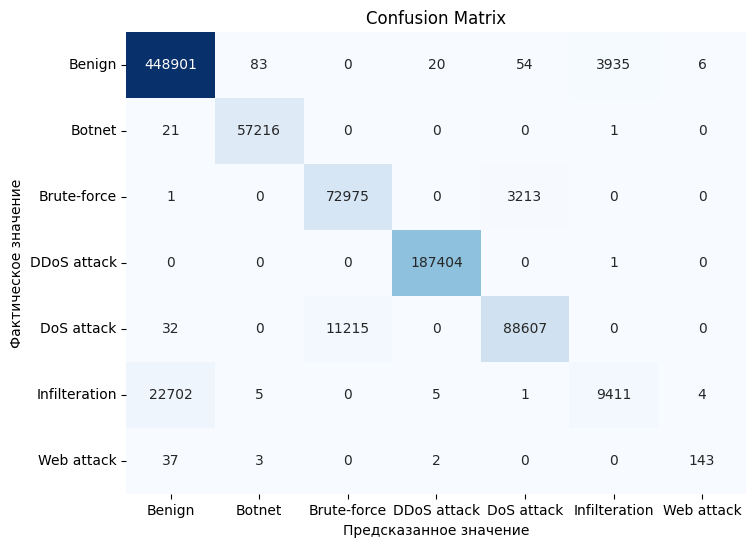

Best Parameters: {'learning_rate': 0.4868509098584437, 'max_depth': 28, 'subsample': 0.934616402424582, 'colsample_bytree': 0.6466605691107212, 'n_estimators': 846, 'gamma': 1.0176294601422209}

Top 10 Features:


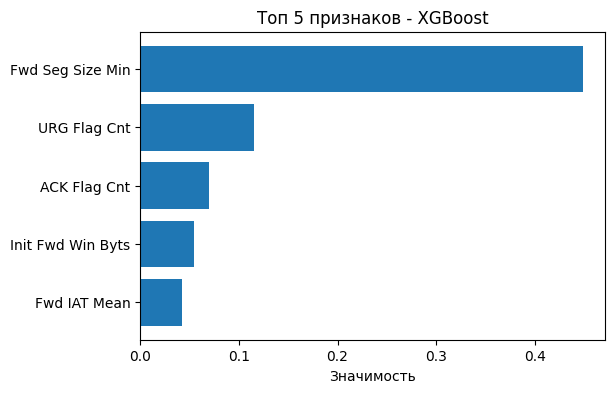

              Feature  Importance
18   Fwd Seg Size Min    0.449158
10       URG Flag Cnt    0.115278
9        ACK Flag Cnt    0.069913
15  Init Fwd Win Byts    0.054464
1        Fwd IAT Mean    0.042147


In [ ]:
def objective_xgb(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
        "max_depth": trial.suggest_int("max_depth", 3, 32),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "gamma": trial.suggest_float("gamma", 0, 10),
    }

    model = XGBClassifier(
        **params, use_label_encoder=False, eval_metric="mlogloss", random_state=2003
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred, average="weighted")


sampler = optuna.samplers.TPESampler(seed=2003)
study_xgb = optuna.create_study(direction="maximize", sampler=sampler)
study_xgb.optimize(objective_xgb, n_trials=5)

best_xgb = XGBClassifier(
    **study_xgb.best_params,
    use_label_encoder=False,
    eval_metric="mlogloss",
    random_state=2003,
)
X_train_full = np.vstack((X_train, X_val))
y_train_full = np.concatenate((y_train, y_val))
best_xgb.fit(X_train_full, y_train_full)

print("\nXGBoost Results:")
evaluate_model(best_xgb, X_test, y_test)
print("Best Parameters:", study_xgb.best_params)

print("\nTop 10 Features:")
feature_imp_xgb = plot_top_features(best_xgb, X.columns, "XGBoost")
print(feature_imp_xgb)


# ====================
# CATBOOST
# ====================

[I 2025-04-09 17:34:35,643] A new study created in memory with name: no-name-0544466a-bab0-43e8-a3a1-92c27c7e4fb4
[I 2025-04-09 17:42:55,112] Trial 0 finished with value: 0.9475218939668663 and parameters: {'depth': 7, 'learning_rate': 0.22335138511519664, 'l2_leaf_reg': 4.051344167564791, 'iterations': 412, 'border_count': 221}. Best is trial 0 with value: 0.9475218939668663.
[I 2025-04-09 17:49:40,253] Trial 1 finished with value: 0.9472511915705254 and parameters: {'depth': 5, 'learning_rate': 0.4868509098584437, 'l2_leaf_reg': 8.3779800073282, 'iterations': 883, 'border_count': 97}. Best is trial 0 with value: 0.9475218939668663.
[I 2025-04-09 18:01:35,341] Trial 2 finished with value: 0.9459606128897138 and parameters: {'depth': 9, 'learning_rate': 0.05177971006109682, 'l2_leaf_reg': 6.45592551230814, 'iterations': 501, 'border_count': 51}. Best is trial 0 with value: 0.9475218939668663.
[I 2025-04-09 20:13:09,415] Trial 3 finished with value: 0.9480732300583194 and parameters: {'


CatBoost Results:
Accuracy: 0.954228375780079
Precision: 0.9500353867782217
Recall: 0.954228375780079
F1-Score: 0.9482886328173347
Weighted ROC-AUC: 0.9940422643415964

Classification Report:
               precision    recall  f1-score   support

       Benign       0.95      0.99      0.97    452999
       Botnet       1.00      1.00      1.00     57238
  Brute-force       0.87      0.95      0.91     76189
  DDoS attack       1.00      1.00      1.00    187405
   DoS attack       0.96      0.89      0.92     99854
Infilteration       0.72      0.29      0.41     32128
   Web attack       0.93      0.77      0.85       185

     accuracy                           0.95    905998
    macro avg       0.92      0.84      0.87    905998
 weighted avg       0.95      0.95      0.95    905998

ROC-AUC для классов:
Benign: 0.993
Botnet: 1.000
Brute-force: 0.997
DDoS attack: 1.000
DoS attack: 0.998
Infilteration: 0.947
Web attack: 1.000


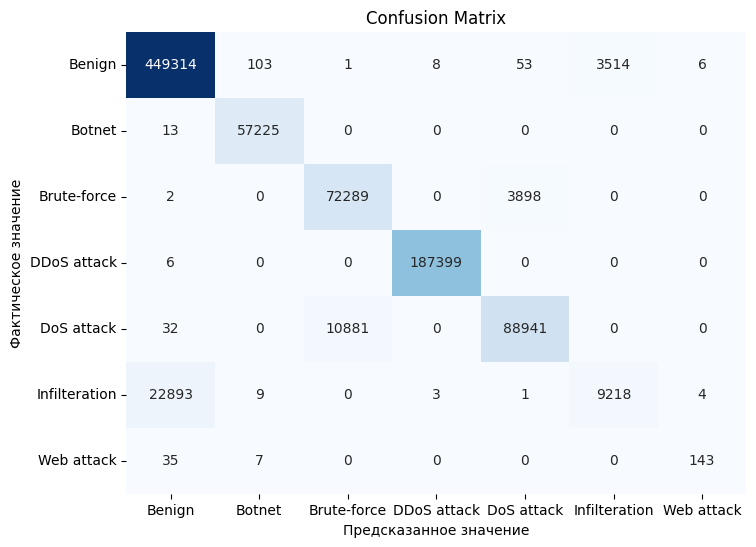

Best Parameters: {'depth': 9, 'learning_rate': 0.46793544397888603, 'l2_leaf_reg': 5.164068774116758, 'iterations': 863, 'border_count': 197}

Top 10 Features:


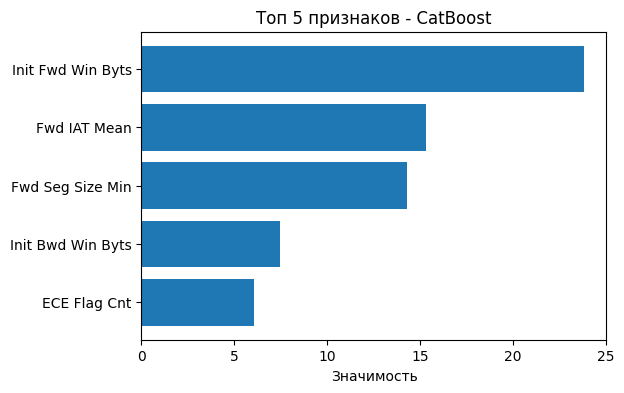

              Feature  Importance
15  Init Fwd Win Byts   23.829750
1        Fwd IAT Mean   15.291623
18   Fwd Seg Size Min   14.305557
16  Init Bwd Win Byts    7.436629
11       ECE Flag Cnt    6.055666


In [ ]:
def objective_cb(trial):
    params = {
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-4, 10),
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "auto_class_weights": trial.suggest_categorical("auto_class_weights", [None, "Balanced"]),
    }

    model = CatBoostClassifier(**params, verbose=0, random_state=2003)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred, average="weighted")


sampler = optuna.samplers.TPESampler(seed=2003)
study_cb = optuna.create_study(direction="maximize", sampler=sampler)
study_cb.optimize(objective_cb, n_trials=5)

best_cb = CatBoostClassifier(**study_cb.best_params, verbose=0, random_state=2003)
X_train_full = np.vstack((X_train, X_val))
y_train_full = np.concatenate((y_train, y_val))
best_cb.fit(X_train_full, y_train_full)

print("\nCatBoost Results:")
evaluate_model(best_cb, X_test, y_test)
print("Best Parameters:", study_cb.best_params)

print("\nTop 10 Features:")
feature_imp_cb = plot_top_features(best_cb, X.columns, "CatBoost")
print(feature_imp_cb)


# ===============
# Transformer
# ===============

In [ ]:
def predict_pytorch_model_with_proba(model, X_data, device, batch_size=64):
    model.eval()
    all_preds = []
    all_probas = []

    dataset = torch.utils.data.TensorDataset(torch.tensor(X_data, dtype=torch.float32))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for (batch_x,) in dataloader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            probas = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = np.argmax(probas, axis=1)

            all_preds.append(preds)
            all_probas.append(probas)

    y_pred = np.concatenate(all_preds)
    y_proba = np.concatenate(all_probas)
    return y_pred, y_proba


In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device


device(type='mps')

[I 2025-04-12 11:13:08,677] A new study created in memory with name: no-name-eecdaa29-4207-4385-93ac-1ec60991be94


[Trial 0] Epoch 1/5, Train Loss: 0.2246, Val F1: 0.9322
[Trial 0] Epoch 2/5, Train Loss: 0.1693, Val F1: 0.9350
[Trial 0] Epoch 3/5, Train Loss: 0.1635, Val F1: 0.9374
[Trial 0] Epoch 4/5, Train Loss: 0.1596, Val F1: 0.9387


[I 2025-04-12 12:58:07,964] Trial 0 finished with value: 0.9387393722935066 and parameters: {'d_model': 32, 'n_heads': 4, 'num_layers': 3, 'dim_feedforward': 128, 'dropout': 0.24849858452867624, 'lr': 0.00015978127855783815, 'batch_size': 32, 'n_epochs': 5}. Best is trial 0 with value: 0.9387393722935066.


[Trial 0] Epoch 5/5, Train Loss: 0.1581, Val F1: 0.9342
[Trial 1] Epoch 1/5, Train Loss: 0.9683, Val F1: 0.6518
[Trial 1] Epoch 2/5, Train Loss: 0.8092, Val F1: 0.7115
[Trial 1] Epoch 3/5, Train Loss: 0.7421, Val F1: 0.5524
[Trial 1] Epoch 4/5, Train Loss: 0.9621, Val F1: 0.6019


[I 2025-04-12 14:20:15,546] Trial 1 finished with value: 0.711513758218515 and parameters: {'d_model': 64, 'n_heads': 2, 'num_layers': 2, 'dim_feedforward': 256, 'dropout': 0.1369863865113855, 'lr': 0.007997578128244604, 'batch_size': 32, 'n_epochs': 5}. Best is trial 0 with value: 0.9387393722935066.


[Trial 1] Epoch 5/5, Train Loss: 0.9383, Val F1: 0.6044
[Trial 2] Epoch 1/5, Train Loss: 0.2383, Val F1: 0.9324
[Trial 2] Epoch 2/5, Train Loss: 0.1724, Val F1: 0.9364
[Trial 2] Epoch 3/5, Train Loss: 0.1663, Val F1: 0.9365
[Trial 2] Epoch 4/5, Train Loss: 0.1634, Val F1: 0.9362


[I 2025-04-12 14:49:29,290] Trial 2 finished with value: 0.9374762840779088 and parameters: {'d_model': 32, 'n_heads': 2, 'num_layers': 3, 'dim_feedforward': 128, 'dropout': 0.2832931834409874, 'lr': 0.0004207152186049736, 'batch_size': 128, 'n_epochs': 5}. Best is trial 0 with value: 0.9387393722935066.


[Trial 2] Epoch 5/5, Train Loss: 0.1604, Val F1: 0.9375
[Trial 3] Epoch 1/5, Train Loss: 1.4193, Val F1: 0.3333
[Trial 3] Epoch 2/5, Train Loss: 1.4187, Val F1: 0.3333
[Trial 3] Epoch 3/5, Train Loss: 1.4187, Val F1: 0.3333
[Trial 3] Epoch 4/5, Train Loss: 1.4187, Val F1: 0.3333


[I 2025-04-12 15:55:44,194] Trial 3 finished with value: 0.3333333333333333 and parameters: {'d_model': 128, 'n_heads': 8, 'num_layers': 3, 'dim_feedforward': 256, 'dropout': 0.24875348697768576, 'lr': 0.004995137479673387, 'batch_size': 64, 'n_epochs': 5}. Best is trial 0 with value: 0.9387393722935066.


[Trial 3] Epoch 5/5, Train Loss: 1.4187, Val F1: 0.3333
[Trial 4] Epoch 1/5, Train Loss: 0.2611, Val F1: 0.8785
[Trial 4] Epoch 2/5, Train Loss: 0.2543, Val F1: 0.8925
[Trial 4] Epoch 3/5, Train Loss: 0.2470, Val F1: 0.8762
[Trial 4] Epoch 4/5, Train Loss: 0.2311, Val F1: 0.9087


[I 2025-04-12 17:48:23,776] Trial 4 finished with value: 0.9201464162994334 and parameters: {'d_model': 64, 'n_heads': 8, 'num_layers': 3, 'dim_feedforward': 128, 'dropout': 0.2897928083107679, 'lr': 0.0016504950880056, 'batch_size': 32, 'n_epochs': 5}. Best is trial 0 with value: 0.9387393722935066.


[Trial 4] Epoch 5/5, Train Loss: 0.2302, Val F1: 0.9201

=== Best Params ===
{'d_model': 32, 'n_heads': 4, 'num_layers': 3, 'dim_feedforward': 128, 'dropout': 0.24849858452867624, 'lr': 0.00015978127855783815, 'batch_size': 32, 'n_epochs': 5}
[Final Model] Epoch 1/5, Train Loss: 0.2011
[Final Model] Epoch 2/5, Train Loss: 0.1635
[Final Model] Epoch 3/5, Train Loss: 0.1586
[Final Model] Epoch 4/5, Train Loss: 0.1559
[Final Model] Epoch 5/5, Train Loss: 0.1539

=== Transformer Model Results on Test ===
Accuracy: 0.9453530802496253
Precision: 0.9407878815843672
Recall: 0.9453530802496253
F1-Score: 0.937340721358791

Classification Report:
               precision    recall  f1-score   support

       Benign       0.94      0.99      0.96    452999
       Botnet       0.96      0.95      0.96     57238
  Brute-force       0.87      0.94      0.90     76189
  DDoS attack       1.00      1.00      1.00    187405
   DoS attack       0.94      0.89      0.91     99854
Infilteration       0.74 

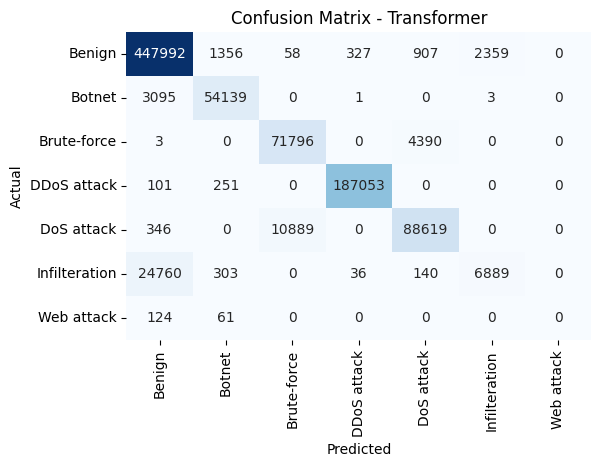

Best Parameters: {'d_model': 32, 'n_heads': 4, 'num_layers': 3, 'dim_feedforward': 128, 'dropout': 0.24849858452867624, 'lr': 0.00015978127855783815, 'batch_size': 32, 'n_epochs': 5}


In [ ]:

class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        if hasattr(y, "values"):
            self.y = torch.tensor(y.values, dtype=torch.long)
        else:
            self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def create_dataloaders(X_train, y_train, X_val, y_val, batch_size=64):
    train_dataset = TabularDataset(X_train, y_train)
    val_dataset = TabularDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


class TransformerForTabular(nn.Module):

    def __init__(
        self,
        num_features: int,
        num_classes: int,
        d_model: int,
        n_heads: int,
        num_layers: int,
        dim_feedforward: int,
        dropout: float,
    ):
        super().__init__()

        self.num_features = num_features
        self.d_model = d_model

        self.input_embedding = nn.Linear(1, d_model)

        self.pos_embedding = nn.Parameter(torch.zeros(1, num_features, d_model))


        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )

        self.classifier = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, num_classes),
        )

    def forward(self, x):

        x = x.unsqueeze(-1)
        x = self.input_embedding(x)
        x = x + self.pos_embedding[:, : self.num_features, :]
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)

        out = self.classifier(x)
        return out


def train_one_epoch(model, optimizer, criterion, dataloader, device):
    model.train()
    total_loss = 0
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu())
            all_targets.append(batch_y.cpu())
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    return f1_score(all_targets, all_preds, average="weighted")



def objective_transformer(trial):

    d_model = trial.suggest_categorical("d_model", [32, 64, 128])
    n_heads = trial.suggest_categorical("n_heads", [2, 4, 8])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dim_feedforward = trial.suggest_categorical("dim_feedforward", [64, 128, 256])
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    n_epochs = trial.suggest_categorical("n_epochs", [5])


    model = TransformerForTabular(
        num_features=X_train.shape[1],
        num_classes=len(set(y_train)),
        d_model=d_model,
        n_heads=n_heads,
        num_layers=num_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout,
    ).to(device)

    train_loader, val_loader = create_dataloaders(
        X_train, y_train, X_val, y_val, batch_size=batch_size
    )


    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    best_val_f1 = 0.0

    for epoch in range(n_epochs):
        train_loss = train_one_epoch(model, optimizer, criterion, train_loader, device)
        val_f1 = evaluate(model, val_loader, device)

        print(
            f"[Trial {trial.number}] "
            f"Epoch {epoch + 1}/{n_epochs}, "
            f"Train Loss: {train_loss:.4f}, "
            f"Val F1: {val_f1:.4f}"
        )

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1


    return best_val_f1


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


sampler = optuna.samplers.TPESampler(seed=2003)
study_transformer = optuna.create_study(direction="maximize", sampler=sampler)
study_transformer.optimize(objective_transformer, n_trials=5)

best_params = study_transformer.best_params
print("\n=== Best Params ===")
print(best_params)


best_model = TransformerForTabular(
    num_features=X_train.shape[1],
    num_classes=len(set(y_train)),
    d_model=best_params["d_model"],
    n_heads=best_params["n_heads"],
    num_layers=best_params["num_layers"],
    dim_feedforward=best_params["dim_feedforward"],
    dropout=best_params["dropout"],
).to(device)


X_train_full = np.vstack((X_train, X_val))
y_train_full = np.concatenate((y_train, y_val))

full_train_dataset = TabularDataset(X_train_full, y_train_full)
full_train_loader = DataLoader(
    full_train_dataset,
    batch_size=best_params["batch_size"],
    shuffle=True
)

optimizer = torch.optim.Adam(
    best_model.parameters(),
    lr=best_params["lr"],
)
criterion = nn.CrossEntropyLoss()


for epoch in range(best_params["n_epochs"]):
    train_loss = train_one_epoch(best_model, optimizer, criterion, full_train_loader, device)
    print(f"[Final Model] Epoch {epoch + 1}/{best_params['n_epochs']}, Train Loss: {train_loss:.4f}")


print("\n=== Transformer Model Results on Test ===")
y_pred_test, y_proba_test = predict_pytorch_model_with_proba(best_model, X_test, device)

acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test, average="weighted")
rec = recall_score(y_test, y_pred_test, average="weighted")
f1 = f1_score(y_test, y_pred_test, average="weighted")

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-Score:", f1)


print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=class_names))


try:
    y_test_bin = label_binarize(y_test, classes=range(len(class_names)))

    roc_auc_per_class = roc_auc_score(y_test_bin, y_proba_test, average=None)
    roc_auc_weighted = roc_auc_score(y_test_bin, y_proba_test, average="weighted")

    print("\nWeighted ROC-AUC:", roc_auc_weighted)
    print("ROC-AUC для классов:")
    for c_name, auc_score in zip(class_names, roc_auc_per_class):
        print(f"{c_name}: {auc_score:.3f}")
except Exception as e:
    print("ROC-AUC could not be computed:", e)


cm = confusion_matrix(y_test, y_pred_test)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Transformer")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Best Parameters:", best_params)


Было пройдено достаточно много итераций. при этом сохранены лучшие гиперпараметры для модели. используем именно их при обучении и получение результатов на тесте. 

[Final Model] Epoch 1/5, Train Loss: 0.1904
[Final Model] Epoch 2/5, Train Loss: 0.1593
[Final Model] Epoch 3/5, Train Loss: 0.1559
[Final Model] Epoch 4/5, Train Loss: 0.1538
[Final Model] Epoch 5/5, Train Loss: 0.1527

=== Transformer Model Results on Test ===
Accuracy: 0.9461941417089221
Precision: 0.9417508372807151
Recall: 0.9461941417089221
F1-Score: 0.9383542775914756

Classification Report:
               precision    recall  f1-score   support

       Benign       0.94      0.99      0.96    452999
       Botnet       0.96      0.95      0.95     57238
  Brute-force       0.88      0.94      0.91     76189
  DDoS attack       1.00      1.00      1.00    187405
   DoS attack       0.94      0.90      0.92     99854
Infilteration       0.75      0.22      0.34     32128
   Web attack       0.66      0.43      0.52       185

     accuracy                           0.95    905998
    macro avg       0.88      0.77      0.80    905998
 weighted avg       0.94      0.95      0.94  

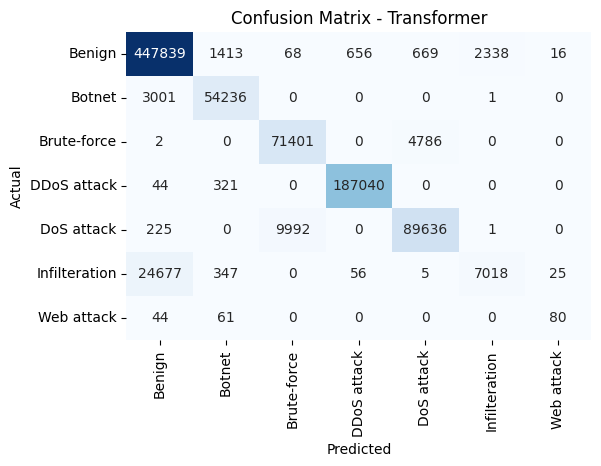

Best Parameters (manual): {'d_model': 32, 'n_heads': 4, 'num_layers': 2, 'dim_feedforward': 256, 'dropout': 0.031108361431471374, 'lr': 0.0005113134439431573, 'batch_size': 64}


In [ ]:
import torch
import numpy as np
from torch.utils.data import DataLoader


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


class TabularDataset(Dataset):
    def __init__(self, X, y):

        self.X = torch.tensor(X, dtype=torch.float32)
        if hasattr(y, "values"):
            self.y = torch.tensor(y.values, dtype=torch.long)
        else:
            self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def create_dataloaders(X_train, y_train, X_val, y_val, batch_size=64):
    train_dataset = TabularDataset(X_train, y_train)
    val_dataset = TabularDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


class TransformerForTabular(nn.Module):
    def __init__(
        self,
        num_features: int,
        num_classes: int,
        d_model: int,
        n_heads: int,
        num_layers: int,
        dim_feedforward: int,
        dropout: float,
    ):
        super().__init__()

        self.num_features = num_features
        self.d_model = d_model


        self.input_embedding = nn.Linear(1, d_model)
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_features, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, num_layers=num_layers
        )


        self.classifier = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, num_classes),
        )

    def forward(self, x):

        x = x.unsqueeze(-1)
        x = self.input_embedding(x)
        x = x + self.pos_embedding[:, : self.num_features, :]
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        out = self.classifier(x)
        return out


def train_one_epoch(model, optimizer, criterion, dataloader, device):
    model.train()
    total_loss = 0
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu())
            all_targets.append(batch_y.cpu())
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    return f1_score(all_targets, all_preds, average="weighted")


best_params = {
    'd_model': 32,
    'n_heads': 4,
    'num_layers': 2,
    'dim_feedforward': 256,
    'dropout': 0.031108361431471374,
    'lr': 0.0005113134439431573,
    'batch_size': 64
}
n_epochs = 5

best_model = TransformerForTabular(
    num_features=X_train.shape[1],
    num_classes=len(set(y_train)),
    d_model=best_params["d_model"],
    n_heads=best_params["n_heads"],
    num_layers=best_params["num_layers"],
    dim_feedforward=best_params["dim_feedforward"],
    dropout=best_params["dropout"],
).to(device)


X_train_full = np.vstack((X_train, X_val))
y_train_full = np.concatenate((y_train, y_val))

full_train_dataset = TabularDataset(X_train_full, y_train_full)
full_train_loader = DataLoader(
    full_train_dataset,
    batch_size=best_params["batch_size"],
    shuffle=True
)

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params["lr"])
criterion = torch.nn.CrossEntropyLoss()


for epoch in range(n_epochs):
    train_loss = train_one_epoch(best_model, optimizer, criterion, full_train_loader, device)
    print(f"[Final Model] Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss:.4f}")


print("\n=== Transformer Model Results on Test ===")
y_pred_test, y_proba_test = predict_pytorch_model_with_proba(best_model, X_test, device)

acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test, average="weighted")
rec = recall_score(y_test, y_pred_test, average="weighted")
f1 = f1_score(y_test, y_pred_test, average="weighted")

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-Score:", f1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=class_names))

try:
    y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
    roc_auc_per_class = roc_auc_score(y_test_bin, y_proba_test, average=None)
    roc_auc_weighted = roc_auc_score(y_test_bin, y_proba_test, average="weighted")

    print("\nWeighted ROC-AUC:", roc_auc_weighted)
    print("ROC-AUC для классов:")
    for c_name, auc_score in zip(class_names, roc_auc_per_class):
        print(f"{c_name}: {auc_score:.3f}")
except Exception as e:
    print("ROC-AUC could not be computed:", e)

cm = confusion_matrix(y_test, y_pred_test)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Transformer")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Best Parameters (manual):", best_params)


Важность признаков

In [ ]:
df = df_all.copy()
le = LabelEncoder()
df["Label"] = le.fit_transform(df["Label"])
class_names = le.classes_

X = df.drop(["Threat", "Label"], axis=1)
y = df["Label"]

feature_names = X.columns.tolist()

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.8, stratify=y, random_state=2003
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.9, stratify=y_temp, random_state=2003
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


val_dataset = TabularDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
baseline_f1 = evaluate(best_model, val_loader, device)

importances = np.zeros(X_val.shape[1])
for col_idx in range(X_val.shape[1]):
    original_col = X_val[:, col_idx].copy()

    np.random.shuffle(X_val[:, col_idx])
    val_dataset_shuffled = TabularDataset(X_val, y_val)
    val_loader_shuffled = DataLoader(val_dataset_shuffled, batch_size=128, shuffle=False)
    f1_shuffled = evaluate(best_model, val_loader_shuffled, device)
    importances[col_idx] = baseline_f1 - f1_shuffled
    X_val[:, col_idx] = original_col
top5_idx = np.argsort(importances)[::-1][:5]

print("\n=== Permutation Feature Importance (Top-5) ===")
for i, idx in enumerate(top5_idx, start=1):
    print(f"{i}. {feature_names[idx]}: {importances[idx]:.4f}")



=== Permutation Feature Importance (Top-5) ===
1. Fwd Seg Size Min: 0.2250
2. Pkt Size Avg: 0.1645
3. ACK Flag Cnt: 0.1168
4. Init Fwd Win Byts: 0.0919
5. Fwd IAT Mean: 0.0573
